# Cross modal segmentation with SAM4D

This notebook shows how to use SAM4D for interactive segmentation in camera and LiDAR streams. It will cover the following:

- adding clicks (or box) on a frame in camera or LiDAR to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire stream. 

## Set-up

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import copy
from sam4d.visualize import sam4d_viz

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Building the SAM4D predictor

In [4]:
from mmengine import Config
from mmengine.registry import MODELS
from sam4d.misc import _load_sam4d_label, concat_points, get_next_point, sample_box_points, _load_checkpoint


def build_sam4d_predictor(
        config_file,
        ckpt_path=None,
        device="cuda",
        mode="eval",
        cfg_options_extra={},
        apply_postprocessing=True,
        **kwargs,
):
    cfg_options = {
        "model.type": "SAM4DPredictor",
    }
    if apply_postprocessing:
        cfg_options_extra = cfg_options_extra.copy()
        cfg_options_extra.update({
            # dynamically fall back to multi-mask if the single mask is not stable
            "model.head.sam.sam_mask_decoder_extra_args.dynamic_multimask_via_stability": True,
            "model.head.sam.sam_mask_decoder_extra_args.dynamic_multimask_stability_delta": 0.05,
            "model.head.sam.sam_mask_decoder_extra_args.dynamic_multimask_stability_thresh": 0.98,
            # the sigmoid mask logits on interacted frames with clicks in the memory encoder so that the encoded masks are exactly as what users see from clicking
            "model.binarize_mask_from_pts_for_mem_enc": False,  # to keep same as training
            # fill small holes in the low-res masks up to `fill_hole_area` (before resizing them to the original video resolution)
            "model.fill_hole_area": 8,
        })

    cfg_options.update(cfg_options_extra)

    # os.environ['INFER_WITH_GT'] = '0'  # do not add gt in pipeline
    cfg = Config.fromfile(config_file)
    if cfg_options is not None:
        cfg.merge_from_dict(cfg_options)

    # model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
    model = MODELS.build(cfg.model)
    model.set_data_pipeline(cfg.data.test.pipeline)
    _load_checkpoint(model, ckpt_path)

    model = model.to(device)
    if mode == "eval":
        model.eval()
    return model



In [5]:
# sam4d_checkpoint = "../checkpoints/sam4d_hieraS_mink34w32.pth"
sam4d_checkpoint = "../data/samples/sam4d_hieraS_mink34w32.pth"
model_cfg = "../configs/sam4d_hieraS_mink34w32.py"

predictor = build_sam4d_predictor(model_cfg, sam4d_checkpoint, device=device)

===== params of pure model: 119.882305 M
===== params of img backbone: 34.316992 M; pts backbone: 26.942688 M; fusion: 53.96356 M; head: 4.659065 M
Loaded checkpoint sucessfully


#### Select an example data

We use data in `../data/samples/waymo` for example, please refer to **Prepare Data** in README.md to get yourself data ready.

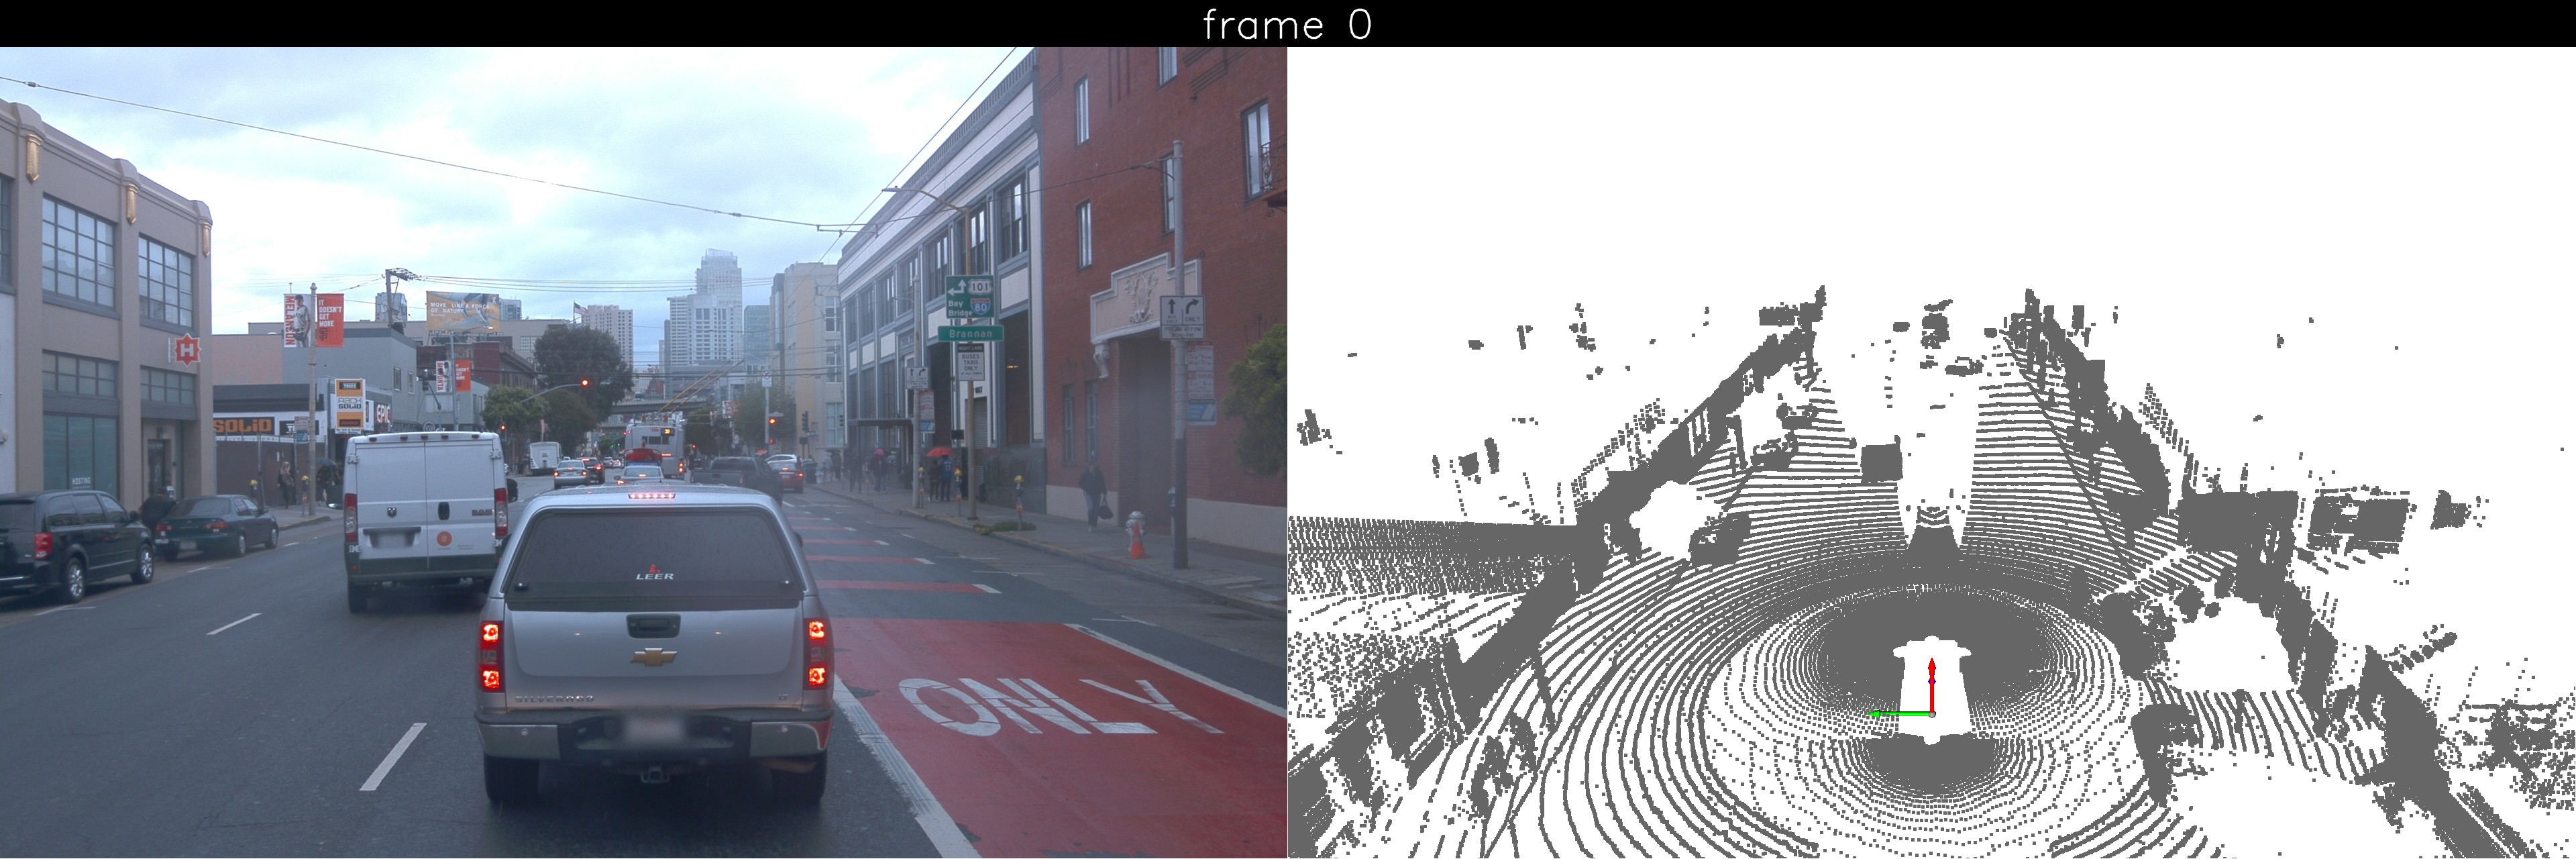

In [6]:
data_dir = "../data/samples/waymo"
seq_name = "segment-10868756386479184868_3000_000_3020_000_with_camera_labels"
cam_name = "FRONT"

with open(os.path.join(data_dir, 'meta_infos', f'{seq_name}.pkl'), 'rb') as f:
    meta_info = pickle.load(f)

img_paths, metas, lidar_paths = [], [], []
for frame_info in meta_info['frames']:
    img_path = os.path.join(data_dir, frame_info['cams_info'][cam_name]['data_path'])
    img_paths.append(img_path)
    camera_intrinsics = np.eye(4)
    camera_intrinsics[:3, :3] = frame_info['cams_info'][cam_name]['camera_intrinsics'][:3, :3]
    metas.append({'pose': frame_info['lidar2world'],
                  'camera_intrinsics': camera_intrinsics,
                  'camera2lidar': frame_info['cams_info'][cam_name]['camera2lidar']})
    lidar_path = os.path.join(data_dir, frame_info['path']['pcd'])
    lidar_paths.append(lidar_path)

# take a look the first frame
frame_idx = 0
img = np.array(Image.open(img_paths[frame_idx]))
pcd = np.load(lidar_paths[frame_idx])['data']

frame_0 = sam4d_viz(img, pcd, title=f'frame {frame_idx}')
display(Image.fromarray(frame_0))

#### Initialize the inference state

SAM4D requires stateful inference for interactive stream segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the camera and LiDAR frames in `img_paths` and `pts_paths`, and stores their data in `inference_state` (as shown in the progress bar below).

In [8]:
inference_state = predictor.init_state(img_paths=img_paths, pts_paths=lidar_paths, metas=metas)

100%|██████████| 199/199 [00:06<00:00, 31.23it/s]


AcceleratorError: CUDA error: an illegal memory access was encountered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [ ]:
predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

To get started, let's try to segment the car on the front.

Here we make a **positive click** at (u, v) = (1000, 1000) in camera with label `1`, by sending their coordinates and labels into the `add_new_points_or_box` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*. In the images, we use green and red pentagrams to represent positive and negative prompts respectively, while in the point clouds we employ green and red spheres for the same purpose.

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Here point_prompts should be a dict
point_prompts = {
    'img': {
        'point_coords': torch.tensor([1000, 1000]).float().reshape(1, 1, 2), # (n_obj, n_prompt, uv)  
        'point_labels': torch.tensor([1]).int().reshape(1, 1),
    },
}
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    point_prompts=copy.deepcopy(point_prompts),
    box_prompts=None,
)

# show the results on the current (interacted) frame
img = np.array(Image.open(os.path.join(img_paths[ann_frame_idx])))
pcd = np.load(lidar_paths[ann_frame_idx])['data']
viz_ret = sam4d_viz(img, pcd, out_mask_logits, out_obj_ids, point_prompts=point_prompts, title=f'frame {frame_idx}')
display(Image.fromarray(viz_ret))

In addition to prompting on images, we can also perform prompting on point clouds. For example, selecting a single point from the point cloud of the vehicle ahead, such as (x, y, z) = (8.9062, 0.1504, 1.4072)

<details>
<summary>
Tips: you can use plotly to interactively pick the point cloud coordinates.
</summary>

```python

import open3d as o3d
import numpy as np
import plotly.graph_objects as go
o3d_pcd = o3d.geometry.PointCloud()
o3d_pcd.points = o3d.utility.Vector3dVector(pcd)

hover_texts = [f"X: {p[0]:.4f}<br>Y: {p[1]:.3f}<br>Z: {p[2]:.3f}" for p in pcd]

fig = go.Figure(
    data=go.Scatter3d(
        x=pcd[:, 0],
        y=pcd[:, 1],
        z=pcd[:, 2],
        mode='markers',
        marker=dict(size=1, color='lightblue', opacity=0.8),
        hoverinfo='text',
        text=hover_texts
    )
)

fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    width=700,
    height=500
)

fig.show()

```

</details>

In [ ]:
predictor.reset_state(inference_state) # dont forget to reset

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Here point_prompts should be a dict
point_prompts = {
    'pts': {
        'point_coords': torch.tensor([8.9062, 0.1504, 1.4072]).float().reshape(1, 1, 3), # (n_obj, n_prompt, xyz)  
        'point_labels': torch.tensor([1]).int().reshape(1, 1),
    },
}
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    point_prompts=copy.deepcopy(point_prompts),
    box_prompts=None,
)

# show the results on the current (interacted) frame
viz_ret = sam4d_viz(img, pcd, out_mask_logits, out_obj_ids, point_prompts=point_prompts, title=f'frame {frame_idx}')
display(Image.fromarray(viz_ret))

#### Step 2: Add a second click (support cross-modal) to refine the prediction

Hmm, it seems that the car's roof isn't well segmented, we can refine it with a second positive click on image.

Here we make a **second positive click** at (u, v) = (830, 741) with label `1` to expand the mask.

Note: we need to send **all the clicks and their labels** (i.e. not just the last click) when calling `add_new_points_or_box`.

<details>
<summary>
Tips: you may use plotly to interactively pick the pixel coordinates.
</summary>
    
```python
from PIL import Image
import plotly.graph_objects as go

fig = go.Figure(go.Image(z=viz_ret))
fig.show()
```

</details>

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (u, v) = (830, 741) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
point_prompts = {
    'pts': {
        'point_coords': torch.tensor([8.9062, 0.1504, 1.4072]).float().reshape(1, 1, 3), # (n_obj, n_prompt, xyz)  
        'point_labels': torch.tensor([1]).int().reshape(1, 1),
    },
    'img': {
        'point_coords': torch.tensor([831, 732]).float().reshape(1, 1, 2), # (n_obj, n_prompt, uv)  
        'point_labels': torch.tensor([1]).int().reshape(1, 1),
    },
}

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    point_prompts=copy.deepcopy(point_prompts),
    box_prompts=None,
)

# show the results on the current (interacted) frame
img = np.array(Image.open(os.path.join(img_paths[ann_frame_idx])))
pcd = np.load(lidar_paths[ann_frame_idx])['data']
viz_ret = sam4d_viz(img, pcd, out_mask_logits, out_obj_ids, point_prompts=point_prompts, title=f'frame {frame_idx}')
display(Image.fromarray(viz_ret))

#### Step 3: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}   # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        'instance_ids': out_obj_ids,
        'mask_logits_dict': out_mask_logits,
    }

# render the segmentation results every few frames
vis_frame_stride = 30
for out_frame_idx in range(0, inference_state['num_frames'], vis_frame_stride):
    cur_img = np.array(Image.open(os.path.join(img_paths[out_frame_idx])))
    cur_pcd = np.load(lidar_paths[out_frame_idx])['data']
    viz_ret = sam4d_viz(cur_img, cur_pcd, **video_segments[out_frame_idx], title=f'frame {out_frame_idx}')
    display(Image.fromarray(viz_ret))

#### Step 4: Add new prompts to further refine the masklet

It appears that in the output masklet above, there are some small imperfections in boundary details on frame 150 of LiDAR.

With SAM4D we can fix the model predictions interactively. We can add a **negative click** in LiDAR-modal at (x, y, z) = (8.2500, -2.771, 0.0008) on this frame with label `0` to refine the masklet. Here we call the `add_new_points_or_box` API with a different `frame_idx` argument to indicate the frame index we want to refine.

<details>
<summary>
Tips: you can use plotly to interactively pick the point cloud coordinates.
</summary>

```python

import open3d as o3d
import numpy as np
import plotly.graph_objects as go

ann_frame_idx = 150
tmp_pcd = np.load(lidar_paths[ann_frame_idx])['data']
tmp_mask = video_segments[ann_frame_idx]['mask_logits_dict']['pts'].cpu().numpy() > 0.0
tmp_pcd = tmp_pcd[tmp_mask[0, 0, :, 0]]
o3d_pcd = o3d.geometry.PointCloud()
o3d_pcd.points = o3d.utility.Vector3dVector(tmp_pcd)


hover_texts = [f"X: {p[0]:.4f}<br>Y: {p[1]:.3f}<br>Z: {p[2]:.3f}" for p in tmp_pcd]

fig = go.Figure(
    data=go.Scatter3d(
        x=tmp_pcd[:, 0],
        y=tmp_pcd[:, 1],
        z=tmp_pcd[:, 2],
        mode='markers',
        marker=dict(size=4, color='lightblue', opacity=0.8),
        hoverinfo='text',
        text=hover_texts
    )
)

fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    width=700,
    height=500
)

fig.show()

```

</details>

In [ ]:
ann_frame_idx = 150  # further refine some details on this frame
ann_obj_id = 1  # give a unique id to the object we interact with (it can be any integers)

# show the segment before further refinement
cur_img = np.array(Image.open(os.path.join(img_paths[ann_frame_idx])))
cur_pcd = np.load(lidar_paths[ann_frame_idx])['data']
viz_ret = sam4d_viz(cur_img, cur_pcd, **video_segments[ann_frame_idx], title=f'frame {ann_frame_idx} -- before refinement')
display(Image.fromarray(viz_ret))

# Let's add a negative click in LiDAR-modal on this frame to refine the segment
point_prompts = {
    # 'img': {
    #     'point_coords': torch.tensor([300, 300, 800, 800, 1000, 1000]).float().reshape(1, 3, 2), # (n_obj, n_prompt, xyz)  
    #     'point_labels': torch.tensor([1, 0, 0]).int().reshape(1, 3),
    # },
    'pts': {
        'point_coords': torch.tensor([8.2500, -2.771, 0.0008]).float().reshape(1, 1, 3), # (n_obj, n_prompt, xyz)  
        # 'point_coords': torch.tensor([8.8906, -1.646, 0.009]).float().reshape(1, 1, 3), # (n_obj, n_prompt, xyz)  
        'point_labels': torch.tensor([0]).int().reshape(1, 1),
    },
}
# inference_state["frames_tracked_per_obj"][0].pop(ann_frame_idx, None) # clear mem
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    point_prompts=copy.deepcopy(point_prompts),
    box_prompts=None,
)

# show the segment after the further refinement
viz_ret = sam4d_viz(cur_img, cur_pcd, out_mask_logits, out_obj_ids, point_prompts=point_prompts, title=f'frame {ann_frame_idx} -- after refinement')
display(Image.fromarray(viz_ret))

#### Step 5: Propagate the prompts (again) to get the masklet across the video

Let's get an updated masklet for the entire video. Here we call `propagate_in_video` again to propagate all the prompts after adding the new refinement click above.

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}   # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        'instance_ids': out_obj_ids,
        'mask_logits_dict': out_mask_logits,
    }

# render the segmentation results every few frames
vis_frame_stride = 30
for out_frame_idx in range(0, inference_state['num_frames'], vis_frame_stride):
    cur_img = np.array(Image.open(os.path.join(img_paths[out_frame_idx])))
    cur_pcd = np.load(lidar_paths[out_frame_idx])['data']
    viz_ret = sam4d_viz(cur_img, cur_pcd, **video_segments[out_frame_idx], title=f'frame {out_frame_idx}')
    display(Image.fromarray(viz_ret))

### Example 2: Segment an object using box prompt

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

In [ ]:
predictor.reset_state(inference_state)

In addition to using clicks as inputs, SAM 2 also supports segmenting and tracking objects in a video via **bounding boxes**.

In the example below, we segment the child on the right using a **box prompt** of (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) on frame 0 as input into the `add_new_points_or_box` API.

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box on image at (x_min, y_min, x_max, y_max) = (495, 644, 762, 876) to get started
box_prompts = {
    'img': {
        'point_coords': torch.tensor([495, 644, 762, 876]).float().reshape(1, 2, 2), # (n_obj, n_prompt, uv)  
        'point_labels': torch.tensor([2, 3]).int().reshape(1, 2),
    },
}
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    point_prompts=None,
    box_prompts=copy.deepcopy(box_prompts),
)

# show the results on the current (interacted) frame
img = np.array(Image.open(os.path.join(img_paths[ann_frame_idx])))
pcd = np.load(lidar_paths[ann_frame_idx])['data']
viz_ret = sam4d_viz(img, pcd, out_mask_logits, out_obj_ids, box_prompts=box_prompts, title=f'frame {frame_idx}')
display(Image.fromarray(viz_ret))

Then, to get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}   # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        'instance_ids': out_obj_ids,
        'mask_logits_dict': out_mask_logits,
    }

# render the segmentation results every few frames
vis_frame_stride = 30
for out_frame_idx in range(0, inference_state['num_frames'], vis_frame_stride):
    cur_img = np.array(Image.open(os.path.join(img_paths[out_frame_idx])))
    cur_pcd = np.load(lidar_paths[out_frame_idx])['data']
    viz_ret = sam4d_viz(cur_img, cur_pcd, **video_segments[out_frame_idx], title=f'frame {out_frame_idx}')
    display(Image.fromarray(viz_ret))

Note that in addition to clicks or boxes, SAM4D also supports directly using a **mask prompt** as input via the `add_new_mask` method in the `SAM4DPredictor` class.

### Example 3: Segment multiple objects simultaneously

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

In [ ]:
predictor.reset_state(inference_state)

#### Step 1: Add two objects on a frame

SAM4D can also segment and track two or more objects at the same time. One way, of course, is to do them one by one. However, it would be more efficient to batch them together (e.g. so that we can share the image features between objects to reduce computation costs).

Add the first object (the left child's shirt) with a **positive click** at (x, y) = (200, 300) on frame 0.

We assign it to object id `2` (it can be arbitrary integers, and only needs to be unique for each object to track), which is passed to the `add_new_points_or_box` API to distinguish the object we are clicking upon.

In [ ]:
# from PIL import Image
# import plotly.graph_objects as go

# fig = go.Figure(go.Image(z=Image.open(os.path.join(img_paths[0]))))
# fig.show()

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Here point_prompts should be a dict
point_prompts = {
    'img': {
        'point_coords': torch.tensor([343, 783]).float().reshape(1, 1, 2), # (n_obj, n_prompt, uv)  
        'point_labels': torch.tensor([1]).int().reshape(1, 1),
    },
}
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    point_prompts=copy.deepcopy(point_prompts),
    box_prompts=None,
)

# show the results on the current (interacted) frame
img = np.array(Image.open(os.path.join(img_paths[ann_frame_idx])))
pcd = np.load(lidar_paths[ann_frame_idx])['data']
viz_ret = sam4d_viz(img, pcd, out_mask_logits, out_obj_ids, point_prompts=point_prompts, title=f'frame {frame_idx}')
display(Image.fromarray(viz_ret))

Hmm, this time we just want to select one black car, but the model predicts two cars in LiDAR modal.. Let's refine the prediction with a **negative click** at (x, y, z) = (21.6758, 9.584, 0.949) in point clouds.


<details>
<summary>
Tips: you can use plotly to interactively pick the point cloud coordinates.
</summary>

```python

import open3d as o3d
import numpy as np
import plotly.graph_objects as go

ann_frame_idx = 0
tmp_pcd = np.load(lidar_paths[ann_frame_idx])['data']
tmp_mask = out_mask_logits['pts'].cpu().numpy() > 0.0
tmp_pcd = tmp_pcd[tmp_mask[0, 0, :, 0]]
o3d_pcd = o3d.geometry.PointCloud()
o3d_pcd.points = o3d.utility.Vector3dVector(tmp_pcd)


hover_texts = [f"X: {p[0]:.4f}<br>Y: {p[1]:.3f}<br>Z: {p[2]:.3f}" for p in tmp_pcd]

fig = go.Figure(
    data=go.Scatter3d(
        x=tmp_pcd[:, 0],
        y=tmp_pcd[:, 1],
        z=tmp_pcd[:, 2],
        mode='markers',
        marker=dict(size=4, color='lightblue', opacity=0.8),
        hoverinfo='text',
        text=hover_texts
    )
)

fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    width=700,
    height=500
)

fig.show()

```

</details>



In [ ]:
# refine the first object
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Here point_prompts should be a dict
point_prompts = {
    'img': {
        'point_coords': torch.tensor([343, 783]).float().reshape(1, 1, 2), # (n_obj, n_prompt, uv)  
        'point_labels': torch.tensor([1]).int().reshape(1, 1),
    },
    'pts': {
        'point_coords': torch.tensor([21.6758, 9.584, 0.949]).float().reshape(1, 1, 3), # (n_obj, n_prompt, xyz)  
        'point_labels': torch.tensor([0]).int().reshape(1, 1),
    },
}
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    point_prompts=copy.deepcopy(point_prompts),
    box_prompts=None,
)

# show the results on the current (interacted) frame
img = np.array(Image.open(os.path.join(img_paths[ann_frame_idx])))
pcd = np.load(lidar_paths[ann_frame_idx])['data']
viz_ret = sam4d_viz(img, pcd, out_mask_logits, out_obj_ids, point_prompts=point_prompts, title=f'frame {frame_idx}')
display(Image.fromarray(viz_ret))

After the 2nd negative click, now we get the left child's shirt as our first object.

Let's move on to the second object (the right child's shirt) with a positive click at (x, y) = (400, 150) on frame 0. Here we assign object id `3` to this second object (it can be arbitrary integers, and only needs to be unique for each object to track).

Note: when there are multiple objects, the `add_new_points_or_box` API will return a list of masks for each object.

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)

# Here point_prompts should be a dict
point_prompts = {
    'img': {
        'point_coords': torch.tensor([1120, 704]).float().reshape(1, 1, 2), # (n_obj, n_prompt, uv)  
        'point_labels': torch.tensor([1]).int().reshape(1, 1),
    },
}
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    point_prompts=copy.deepcopy(point_prompts),
    box_prompts=None,
)

# show the results on the current (interacted) frame
img = np.array(Image.open(os.path.join(img_paths[ann_frame_idx])))
pcd = np.load(lidar_paths[ann_frame_idx])['data']
viz_ret = sam4d_viz(img, pcd, out_mask_logits, out_obj_ids, point_prompts=point_prompts, title=f'frame {frame_idx}')
display(Image.fromarray(viz_ret))

This time the model predicts the mask of the shirt we want to track in just one click. Nice!

#### Step 2: Propagate the prompts to get masklets across the video

Now, we propagate the prompts for both objects to get their masklets throughout the video.

Note: when there are multiple objects, the `propagate_in_video` API will return a list of masks for each object.

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}   # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        'instance_ids': out_obj_ids,
        'mask_logits_dict': out_mask_logits,
    }

# render the segmentation results every few frames
vis_frame_stride = 30
for out_frame_idx in range(0, inference_state['num_frames'], vis_frame_stride):
    cur_img = np.array(Image.open(os.path.join(img_paths[out_frame_idx])))
    cur_pcd = np.load(lidar_paths[out_frame_idx])['data']
    viz_ret = sam4d_viz(cur_img, cur_pcd, **video_segments[out_frame_idx], title=f'frame {out_frame_idx}')
    display(Image.fromarray(viz_ret))